# Data Quality Monitor

In [1]:
'''
Load package. 

Try run this script in analysis directory.
'''

import uproot
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fft import fft, fftfreq, rfft, rfftfreq

In [2]:
# define constants
ADC_TO_MV=2000/(2**14-1)
SAMPLE_TO_NS = 2

In [3]:
"""
OPTIONAL:
    enable interactive plotting. It requires ipympl to be installed. Try: 
        pip install ipympl
    
    Alternative, if you have created a virtual enviroment suggested in README, try:
        source env/bin/activate
"""
#%matplotlib widget

'\nOPTIONAL:\n    enable interactive plotting. It requires ipympl to be installed. Try: \n        pip install ipympl\n    \n    Alternative, if you have created a virtual enviroment suggested in README, try:\n        source env/bin/activate\n'

In [4]:
# define path to your muon file
fpath='../data/phase0_muon_water_220819T1500.root'

## Look at the waveform of an individual event using EventDisplay

In [5]:
# import EventDisplay
import sys
sys.path.append("/Users/xxiang/MyGitHub/Gmail/drop/tools")

# define enviromental variables
%env SOURCE_DIR=../src
%env YAML_DIR=../yaml
from event_display import EventDisplay

# veiw waveform using EventDisplay
dp = EventDisplay(fpath)

env: SOURCE_DIR=../src
env: YAML_DIR=../yaml


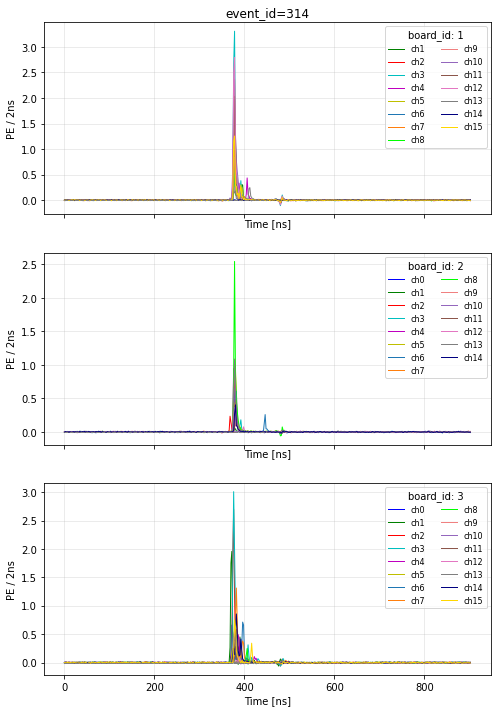

In [6]:
dp.fig_height=3
dp.fig_width=8
dp.display_waveform(314, 'all', baseline_subtracted=True)

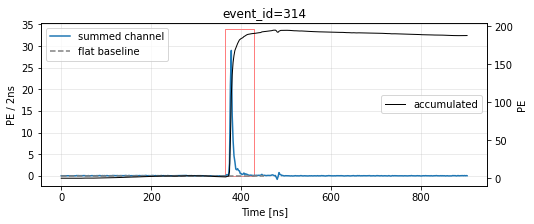

In [7]:
# summed waveform of bottom PMTs
user_list=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')

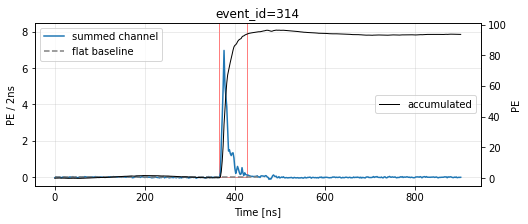

In [8]:
# summed waveform of side PMTs
user_list=[300, 301, 302, 303, 304, 305, 306, 307, 
           308, 309, 310, 311, 312, 313, 314, 315]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')


## Aggregated Analysis 

In [9]:
def correct_trg_delay(adc):
    """
    3 digitizer boards are in daisy chain setup. The delay between TRG_IN and TRG_OUT is 48 ns. 
    To alogn muon pulse, we need to shift the waveform from different boards.
    
    Args:
        adc: dict
    """
    adc_corr = adc.copy()
    dT_ns = 48 # externally calibrated
    dS = dT_ns//2
    for ch, val in adc.items():
        a = np.stack(val)
        if "_b1" in ch:
            a=a[:, dS*2:]
        elif "_b2" in ch:
            a=a[:, dS:-dS]
        elif "_b3" in ch:
            a=a[:, 0:-dS*2]
        else:
            print("ERROR")
            return None
        adc_corr[ch] = a
    return adc_corr

In [10]:
'''
All 48 digitizer channels are active. Only 46 of them are used to digitize PMT signal. Two are used to digitize bottom paddles. 

We did not have SPE calibration of paddles. So we need to exclude the two paddle channels when doing the SPE normalization.
'''
BP_CH_LIST = ['adc_b1_ch0', 'adc_b2_ch15']

In [11]:

def load_data(fpath):
    """
    This function load the root file, and return the data as a dictionary.
    
    Since it loads the entire data set at once, it may take a few minutes.
    
    Args:
        fpath: str. Path to root file
    """
    f = uproot.open(fpath)
    t = f['daq']
    event_id =  t['event_id'].array(library='np')
    event_ttt =  t['event_ttt'].array(library='np')
    n_events=len(event_id)
    
    ch_names = []
    ch_id = []
    for k in t.keys():
        if k[0:4]=='adc_':
            ch_names.append(k)
            tmp = re.findall(r'\d+', k)
            ch_id.append( int(tmp[0])*100+int(tmp[1]) )
    adc =  t.arrays(ch_names, library='np')
    map_ch_name= dict(zip(ch_id, ch_names)) # from ch_id to ch_name
    
    n_samples = len(adc['adc_b1_ch1'][0])
    
    # do a simple flat baseline subtraction
    amp_mV = {}
    amp_pe = {} # unit: pe/ns
    for ch in ch_names:
        amp_mV[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_mV[ch][i] = (np.median(adc[ch][i])-adc[ch][i])*ADC_TO_MV
        if ch in BP_CH_LIST:
            continue
        amp_pe[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_pe[ch][i] = amp_mV[ch][i]/SAMPLE_TO_NS/50/1.6
    
    amp_mV = correct_trg_delay(amp_mV)
    amp_pe = correct_trg_delay(amp_pe)
    
    return dict(
        n_events=n_events,
        n_samples=n_samples,
        event_id=event_id,
        event_ttt=event_ttt,
        ch_names = ch_names,
        ch_id = ch_id,
        amp_mV = amp_mV,
        amp_pe = amp_pe,
    )

data = load_data(fpath)

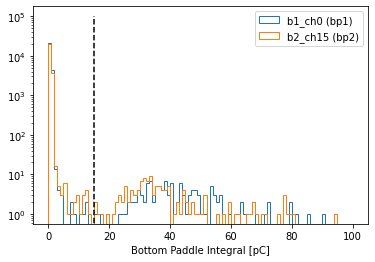

In [12]:
"""
Let's take a look at the area of the two paddles. The area is just integral 
over the entire waveform. Then we convert its unit to charge [pC] (50 Ohm input 
resistance assumed)

Note:
    Since data is a dictionary, you can access its variable via key word. 
Since amp_mV variable is another dictionary, you can access channel via key word
"""
amp_bp1 = data['amp_mV']['adc_b1_ch0'] # bottom paddle 1 baseline subtracted waveform
amp_bp2 = data['amp_mV']['adc_b2_ch15'] # bottom paddle 2 baseline subtracted waveform
area_bp1 = np.sum(amp_bp1, axis=1)*2/50 # unit: pC
area_bp2 = np.sum(amp_bp2, axis=1)*2/50 # unit: pC
plt.figure()
plt.hist(area_bp1, bins=100, range=(0, 100), histtype='step', label='b1_ch0 (bp1)');
plt.hist(area_bp2, bins=100, range=(0, 100), histtype='step', label='b2_ch15 (bp2)');
plt.xlabel('Bottom Paddle Integral [pC]')
plt.legend()
plt.yscale('log')
plt.vlines(15, 0, 1e5, linestyle='--', color='k')
plt.show()

In [15]:
"""
Make a selection of muon passing through bottom paddles
"""
cut_pC=15 # 15pC
print('num of muons through bp1:', len(area_bp1[area_bp1>cut_pC]))
print('num of muons through bp2:', len(area_bp2[area_bp2>cut_pC]))

mask = np.logical_or(area_bp1>cut_pC,  area_bp2>cut_pC)
event_id_selected = data['event_id'][mask]
print("the following muon pass through bot pad:\n", event_id_selected)

num of muons through bp1: 132
num of muons through bp2: 136
the following muon pass through bot pad:
 [  209   406   664   767   848  1024  1243  1299  1376  1410  1444  1465
  1782  2475  2604  2726  2755  2863  2951  3428  3480  3583  3626  3925
  4119  4129  4233  4495  4824  4895  4943  4991  5000  5186  5370  5578
  5673  5788  5828  6335  6498  6566  6640  6964  7046  7284  7411  7658
  7714  7810  8578  8808  8905  8983  9063  9293  9462  9711  9793  9799
  9825  9894  9928 10254 10398 10491 10586 10797 10984 11033 11080 11257
 11334 11450 11746 12533 13131 13205 13347 14503 14637 14856 14945 14018
 14196 15256 15498 15571 16614 16618 16942 16302 17093 17146 17157 17680
 17922 18440 18513 18665 18682 18723 18210 18399 19047 19286 19475 19942
 20616 20958 20043 20340 20444 21204 21369 21423 21600 21724 21867 21999
 22950 23037 23139 23310 23452 23531 23546 23589 23921 24692 24248 24339
 24429 25501 26627 26007 26379 26441 27048 27184 27498 27727 27999 28779
 28930 28965 28194 282

In [16]:
BT_PMT_LIST=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]


def calc_rq_vars(data, BP_CH_LIST=['adc_b1_ch0', 'adc_b2_ch15'], n_events=10000):
    """
    RQ stands for reduced quality. High level variables extracted from waveform.

    Args:
        data: dict. Same data returned by load_data function above.
        BP_CH_LIST: list, bottom paddle channels
        n_events: int, number of events to process

    return: 
        dict
    """
    max_n_events = data['n_events']
    n_samples = data['n_samples']
    if n_events<=0 or n_events>max_n_events:
        n_events=max_n_events
        
    pT_ns=np.zeros(n_events) # peak time
    peak_pe=np.zeros(n_events)
    npe=np.zeros(n_events) # num of pe
    npe_bt=np.zeros(n_events) # num of pe for bt
    npe_side=np.zeros(n_events)
    sba = np.zeros(n_events)
    bp1_area_pC = np.zeros(n_events)
    bp2_area_pC = np.zeros(n_events)
    for i in range(n_events):
        if i % (n_events//10) ==0:
            print("processing ", i)
        amp_sum_pe =0
        amp_bt_pe = 0
        amp_side_pe = 0
        for ch in data['ch_names']:
            if ch in BP_CH_LIST:
                continue
            amp_sum_pe += data['amp_pe'][ch][i]
            if ch in BT_PMT_LIST:
                amp_bt_pe += data['amp_pe'][ch][i]
            else:
                amp_side_pe+= data['amp_pe'][ch][i]
        idx = np.argmax(amp_sum_pe)
        pT_ns[i] = idx*2
        npe[i] = np.sum(amp_sum_pe[160:250])*2
        npe_bt[i] = np.sum(amp_bt_pe[160:250])*2
        npe_side[i] = np.sum(amp_side_pe[160:250])*2
        if (npe_side[i]+npe_bt[i])==0:
            sba[i]=None
        else:
            sba[i] = (npe_side[i]-npe_bt[i])/(npe_side[i]+npe_bt[i])
        peak_pe[i] = np.max(amp_sum_pe[160:250])
        
        bp1_area_pC[i] = np.sum(data['amp_mV']['adc_b1_ch0'][i])*2/50
        bp2_area_pC[i] = np.sum(data['amp_mV']['adc_b2_ch15'][i])*2/50

    return dict(
        npe=npe, # number of total PE by all channels
        npe_bt=npe_bt, # num. of PE from bottom PMTs
        npe_side=npe_side, # num. of PE from side PMTs
        pT_ns=pT_ns, # peak time of summed waveform in ns
        peak_pe=peak_pe,# peak height of summed waveform in pe/2ns
        sba=sba, # side-bottom asymmetry: (npe_side-npe_bt)/npe
        bp1_area_pC=bp1_area_pC, # bot paddle 1 area, unit pC
        bp2_area_pC=bp2_area_pC # bot paddle 2 area, unit pC
    )

rq = calc_rq_vars(data, n_events=100000)

processing  0
processing  5139
processing  10278
processing  15417
processing  20556
processing  25695
processing  30834
processing  35973
processing  41112
processing  46251
processing  51390


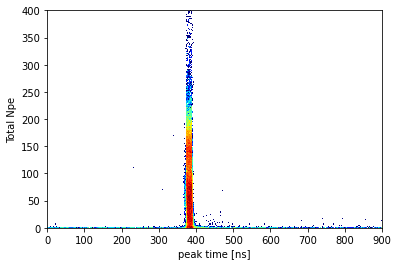

In [17]:
"""
Once you have RQ, making more plots ...
"""

plt.figure()
plt.hist2d(rq['pT_ns'], rq['npe'], bins=[450, 200], range=((0, 900), (0, 400)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.xlabel('peak time [ns]')
plt.ylabel('Total Npe')
plt.show()

In [19]:
"""
mask just means selection; it's an array of bool, can be used to select a variable

Create several mask

- muon_mask = events whose peak time fall within the expected muon region. See the 2D plot above.
- bp_mask = events which produce signals in bottom paddles (see bottom paddle integral plot)
"""
muon_mask = (rq['pT_ns']>=360) & (rq['pT_ns']<400)

bp_mask = np.logical_or(rq['bp1_area_pC']>15, rq['bp2_area_pC']>15) # we actually defined this mask before. 

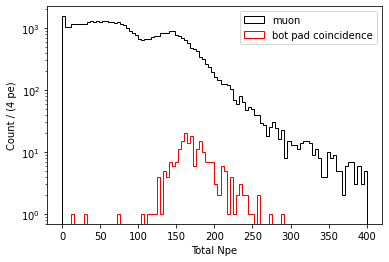

In [20]:
plt.figure()
plt.hist(rq['npe'][muon_mask], bins=100, range=(0, 400), histtype='step', color='black', label='muon');
plt.hist(rq['npe'][bp_mask], bins=100, range=(0, 400), histtype='step', color='red', label='bot pad coincidence');

plt.xlabel('Total Npe')
plt.ylabel('Count / (4 pe)')
plt.yscale('log')
plt.legend()
plt.show()

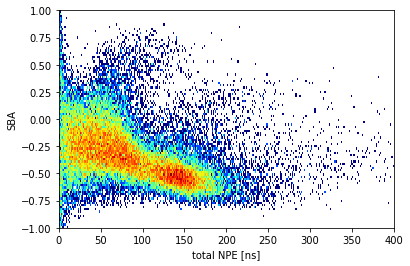

In [21]:
plt.figure()
plt.hist2d(rq['npe'][muon_mask],rq['sba'][muon_mask],  
           bins=[300, 100], range=((0, 400), (-1, 1)), 
            norm=colors.LogNorm(), cmap='jet');
plt.xlabel('total NPE [ns]')
plt.ylabel('SBA')
plt.show()

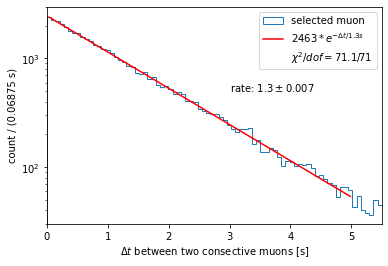

In [22]:
"""
Get event time stamp, select muons, and compute time difference 
between two consective muon
"""
muon_t = data['event_ttt'][muon_mask]*8e-9
dt = muon_t[1:]-muon_t[:-1]


plt.figure()
h = plt.hist(dt, bins=80, range=(0, 5.5), histtype='step', label='selected muon');
plt.yscale('log')
plt.xlabel(r'$\Delta t$ between two consective muons [s]')
plt.ylabel('count / (0.06875 s)')


"""
Do an exponential fit
"""
from scipy.optimize import curve_fit

def expo(x, tau, A):
    return A*np.exp(-x/tau)

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

ydata = h[0]
xdata = (h[1][1:]+h[1][:-1])/2
fit_mask = (xdata>0.0) & (xdata<5)
sigma = np.sqrt(ydata[fit_mask])
popt, pcov = curve_fit(expo, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=(1.2, data['n_events']))
x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
y = expo(x, popt[0], popt[1])

chi2 = calc_chi2(expo, xdata[fit_mask], ydata[fit_mask], popt)
dof = len(xdata[fit_mask])-2
plt.plot(x, y, color='red', label='$%d*e^{-\Delta t / %.1f s}$' % (popt[1], popt[0]))
plt.xlim([0, 5.5])
plt.ylim([30, 3e3])

plt.plot([0,0], [0, 0], color='white', label='$\chi^2/dof=%.1f/%d$'%(chi2, dof))
err = np.diag(pcov)
err = np.sqrt(err)
plt.text(3, 500, r'rate: $%.1f \pm %.3f$' % (popt[0], err[0]))
plt.legend()

plt.show()

# Below are extra stuff not fully tested yet

In [ ]:
def get_freq_spectrum(a):
    sample_rate=500e6 # 500MHz
    n_samples = len(a)
    duration = n_samples/sample_rate
    a=a-np.mean(a)
    yf = rfft(a)
    xf = rfftfreq(n_samples, 1 / sample_rate)
    return xf, yf
    

def get_avg_freq_per_time_slice(adc_b2_ch1, event_id):
    
    trg_rate= 1
    sample_rate=500e6 # 500MHz
    
    dt = (event_id-event_id.min())/trg_rate
    
    n_avg = 50000
    yf_avg = []
    xf_avg = []
    dt_h = []
    n_events = len(event_id)
#     n_events=10000
    for i in range(len(event_id)):
        xf, yf = get_freq_spectrum(adc_b2_ch1[i])
        if i % n_avg == 0:
            if i == 0:
                y_avg = yf
            else:
                yf = yf/n_avg
                yf_avg.append(y_avg)
                xf_avg.append(xf)
                dt_h.append(dt[i])
                y_avg = yf
        else:
            y_avg += yf
            
    dt_l = np.array(dt_h) - (dt[n_avg]-dt[0])
    return dt_l, np.array(xf_avg), np.array(yf_avg)

def get_avg_freq_per_run(data, chName='adc_b1_ch14', n_events=1000):
    
    if n_events<=0 or n_events>data['n_events']:
        n_events=data['n_events']
    
    amp = data['amp_mV'][chName]
    yf_avg = []
    xf_avg = []
    for i in range(n_events):
        xf, yf = get_freq_spectrum(amp[i])
        if i == 0:
            y_avg = yf
        else:
            y_avg += yf
    y_avg = y_avg/n_events
    yf_avg.append(y_avg)
    xf_avg.append(xf)
    return np.array(xf_avg), np.array(yf_avg)

In [ ]:
xf, yf = get_avg_freq_per_run(data, chName="adc_b1_ch14", n_events=100)

In [ ]:


plt.plot(xf[1:], np.abs(yf[1:]))
plt.yscale('log')
plt.xlim([1/(500*2*1e-9), 3e8])
# plt.ylim([0, 6.5e6])

plt.xlabel('Freq [Hz]')
plt.ylabel('ADC (abs)')
plt.title('LED Off Run (June 15 2022); b3p1', fontsize=14);
plt.show()